In [267]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime

In [ ]:
datetime.date.timetuple()

In [140]:
energy = pd.read_csv('octopus.csv').rename(columns={'Unnamed: 0': 'Date'})
energy['Date'] = pd.to_datetime(energy['Date'], format='%Y-%m-%d %H:%M:%S')
energy['Week'] = energy.Date.dt.week
energy['Date_'] = energy.Date.dt.date
#energy['Time'] = energy.Date.dt.time

week_time = []
for date_time in energy.Date:
    week_time.append(datetime.timedelta(days=date_time.dayofweek, hours=date_time.hour, minutes=date_time.minute))
energy['Weektime'] = week_time

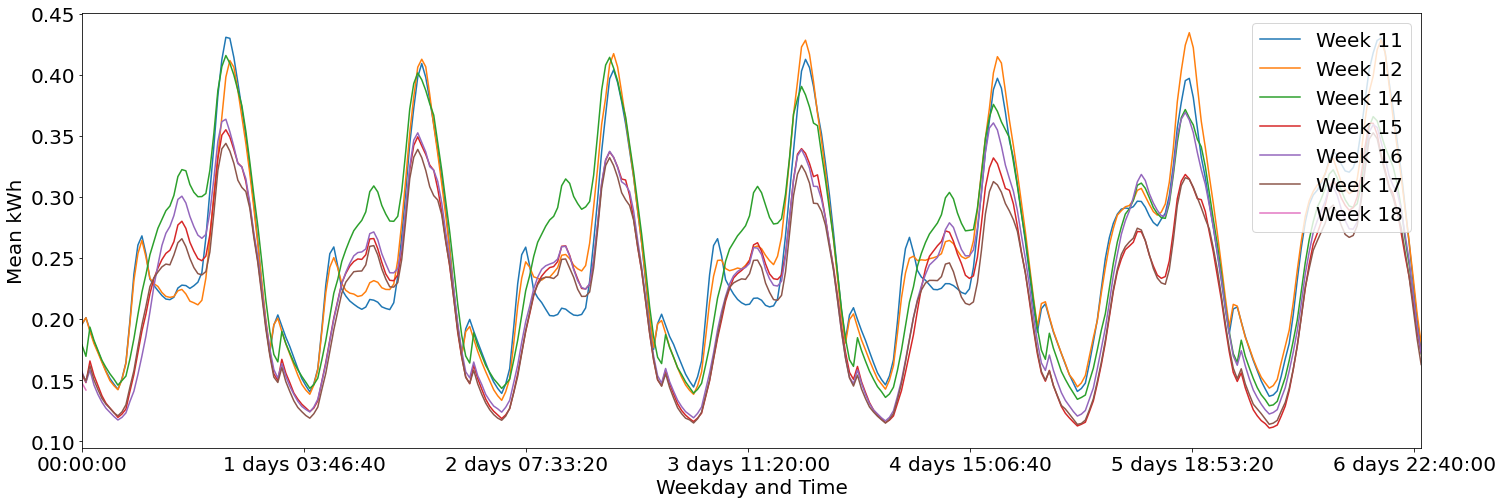

In [141]:
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(24,8))

for week, week_data in energy.groupby('Week'):
    week_data.plot('Weektime', 'Electricity', ax=ax, label='Week {}'.format(week))

ax.set_xlabel('Weekday and Time'); ax.set_ylabel('Mean kWh')
plt.legend(loc=1)
plt.show()

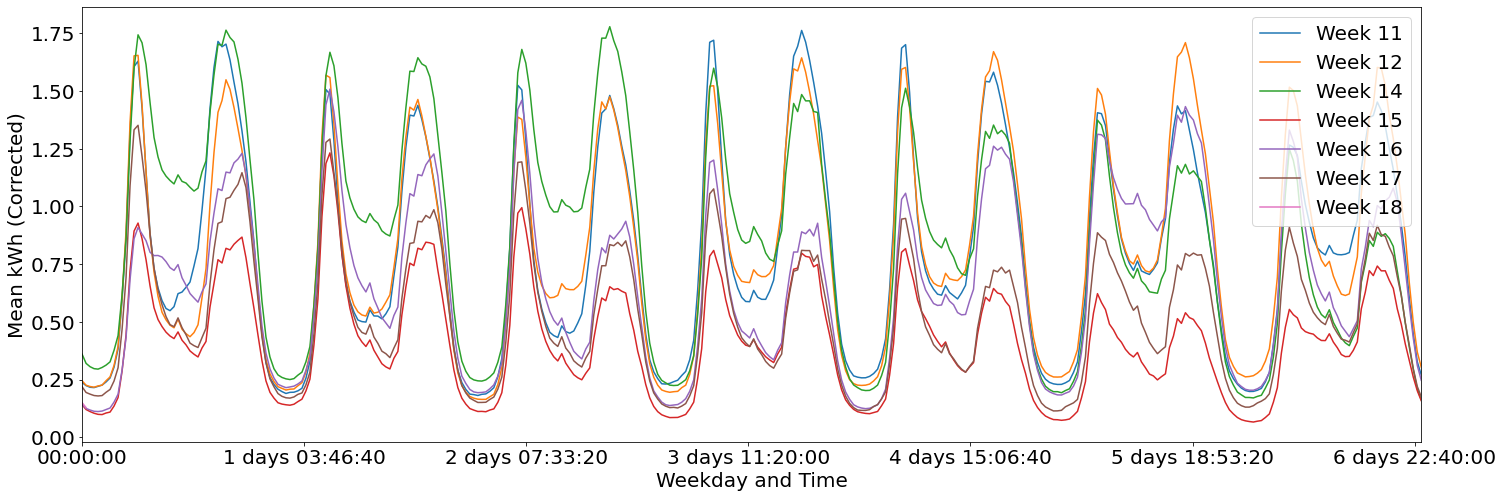

In [142]:
fig, ax = plt.subplots(figsize=(24,8))
for week, week_data in energy.groupby('Week'):
    week_data.plot('Weektime', 'Gas (corrected)', ax=ax, label='Week {}'.format(week))
ax.set_xlabel('Weekday and Time'); ax.set_ylabel('Mean kWh (Corrected)')
plt.legend(loc=1)
plt.show()

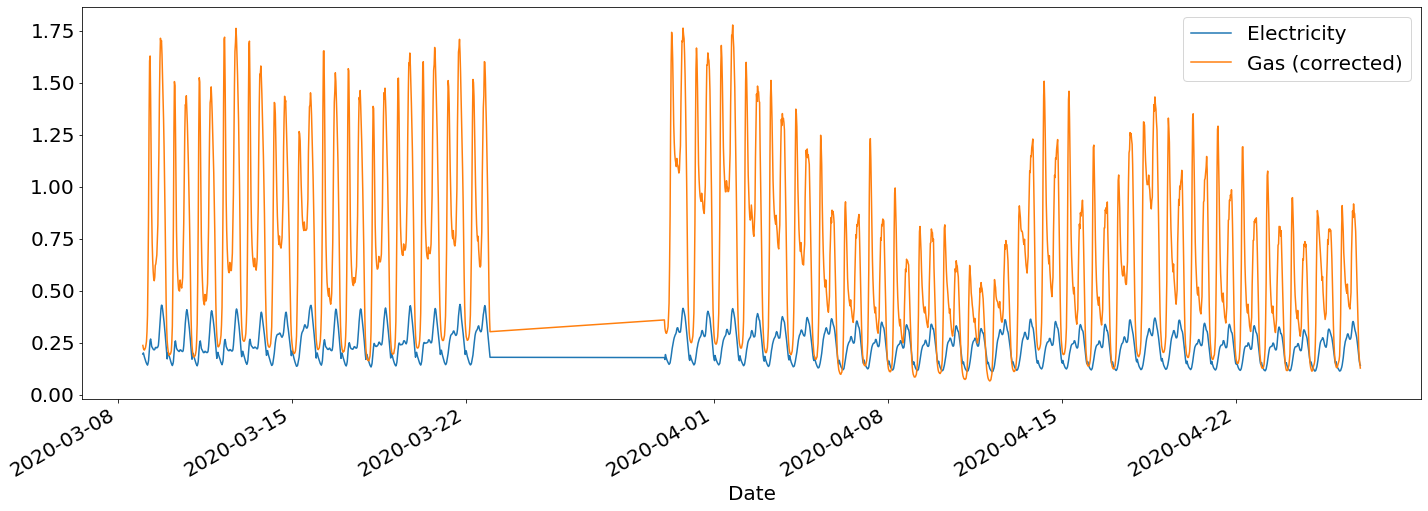

In [143]:
energy.plot('Date', ['Electricity', 'Gas (corrected)'], figsize=(24,8))
plt.show()

In [178]:
energy_average = energy.groupby('Date_').agg(electricity_daily_total = pd.NamedAgg('Electricity', np.sum),
                                             gas_daily_mean = pd.NamedAgg('Gas (corrected)', np.mean)).reset_index()
energy_average.drop(energy_average.tail(1).index,inplace=True)

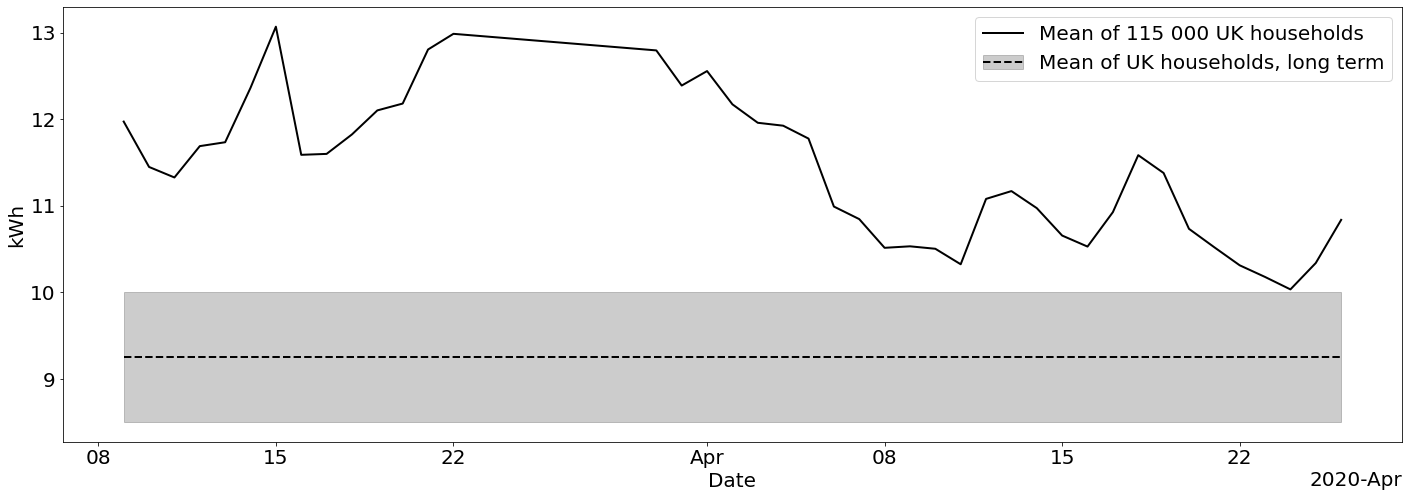

In [315]:
locator = mdates.AutoDateLocator(minticks=6, maxticks=12)
formatter = mdates.ConciseDateFormatter(locator)

fig, ax = plt.subplots(figsize=(24,8))

fill = ax.fill_between(energy_average['Date_'], 8.5*np.ones(len(energy_average)), 10*np.ones(len(energy_average)), color='k', alpha=0.2)
dashed = ax.plot(energy_average['Date_'], 9.25*np.ones(len(energy_average)), c='k', linestyle='dashed', linewidth=2)
electricity = ax.plot(energy_average['Date_'], energy_average['electricity_daily_total'], c='k', linewidth=2)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Date'); ax.set_ylabel('kWh')
plt.legend([electricity[0], (fill, dashed[0])], ['Mean of 115 000 UK households', 'Mean of UK households, long term'])
plt.show()

In [256]:
weather = pd.read_csv('UK_weather.csv')
weather.date = pd.to_datetime(weather['date'], format='%d/%m/%Y')
energy_and_weather = energy_average.join(weather)

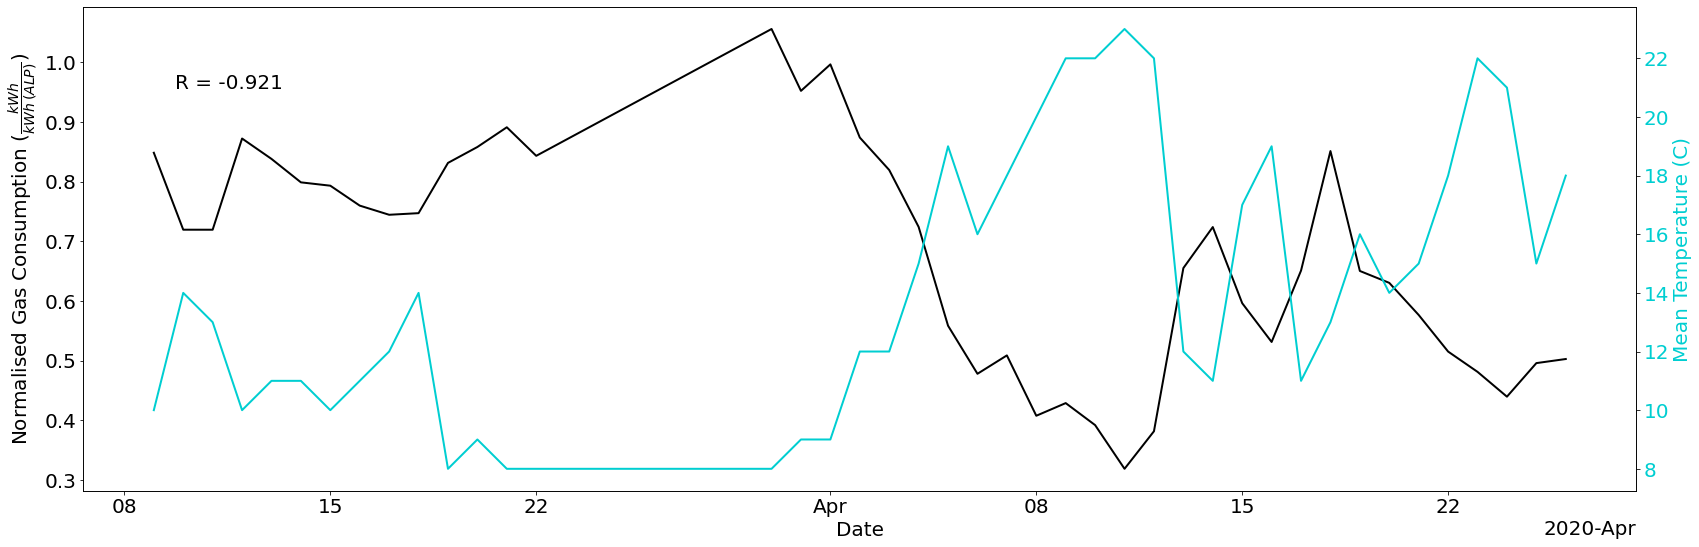

In [284]:
fig, ax1 = plt.subplots(figsize=(24,8))

locator = mdates.AutoDateLocator(minticks=6, maxticks=12)
formatter = mdates.ConciseDateFormatter(locator)

color = 'k'
ax1.set_xlabel('Date'); ax1.xaxis.set_major_locator(locator); ax1.xaxis.set_major_formatter(formatter)
ax1.set_ylabel('Normalised Gas Consumption $(\\frac{kWh}{kWh \: (ALP)})$', color=color)
ax1.plot(energy_and_weather['Date_'], energy_and_weather['gas_daily_mean'], color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'darkturquoise'
ax2.xaxis.set_major_locator(locator); ax2.xaxis.set_major_formatter(formatter)
ax2.set_ylabel('Mean Temperature (C)', color=color)  # we already handled the x-label with ax1
ax2.plot(energy_and_weather['Date_'], energy_and_weather['temperature'], color=color, linewidth=2)
#ax2.set_ylim(0,160000)
ax2.tick_params(axis='y', labelcolor=color)

plt.text(0.01, 0.9, 'R = {0:.3f}'.format(np.corrcoef(energy_and_weather['gas_daily_mean'], energy_and_weather['temperature'])[0,1]), ha='center', va='center', transform=ax.transAxes)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()